Продолжайте развивать генератор данных.

Решите задачу трекинга объектов.

# Этап 1. Генератор последовательности кадров с потоком клеток, перемещающихся "слева - направо".

- сгенерировать последовательность кадров в 10 секунд (итого - примерно 240 кдаров)

- первичное положение клеток - случайный пиксель

- при достижении границы изображения объект прекращает свое существование

- пусть генератор пути клеток позволяет перемещать клетку по синусоиде  y(x(t) ) = ax+b + c * sin( omega *x) + eps_noise 

- a,b,c omega - случайно сгенерированные значения для данной клетки  

- eps_noise - случайное значение для каждой секунды

- 10 секунду - 10 отсчетов времени t,  положение между кажром 0 и кадром 24 интерполируется при помощи линейной интерполяции по формуле: 

- выполнить то же самое, только зависимость не T(z),как в примере, а y(x)

# Этап 2. Трекинг объектов.
Используя пример, приведенный в лекции про трекинг, решить задачу трекинга объектов

Пути (положения) объктов на каждом кадре сохранить в файл.

Визуализировать траектории объектов на изображении.

Video saved as tracked_video.mp4
Tracking complete.
Tracked paths saved to tracked_paths.npy


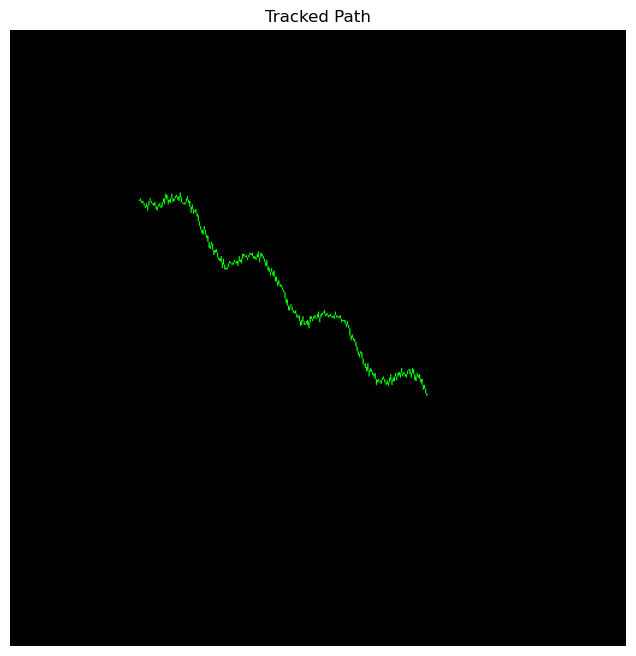

In [4]:
import cv2
import numpy as np
import random
import math
import os
from base64 import b64encode
import matplotlib.pyplot as plt

def generate_cell_path(width, height):
    a = random.uniform(0.5, 1.5)
    b = random.uniform(-50, 50)
    c = random.uniform(-20, 20)
    omega = random.uniform(0.05, 0.2)
    def path(x):
        eps_noise = random.uniform(-5, 5)
        y = a * x + b + c * np.sin(omega * x) + eps_noise
        is_alive = (x < width) and (0 <= y < height)
        return int(x), int(y), is_alive
    return path, a, b, c, omega


def load_images_from_directory(directory):
    images = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):  
                image = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)  
                images.append(image)
    return images


def generate_background(width, height, patches, patch_size):
    background = np.zeros((height, width, 3), dtype=np.uint8)
    patch_width, patch_height = patch_size
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
                patch = random.choice(patches)
                h, w = patch.shape[:2]
                background[y:min(y + h, height), x:min(x + w, width)] = patch[:min(height-y, h), :min(width-x, w)]  
    return background


def generate_frames(width, height, cell, background_patches, patch_size):
    frames = []
    background = generate_background(width, height, background_patches, patch_size)
    start_x = random.randint(0, width // 4)
    start_y = random.randint(0, height)
    cell_path, a, b, c, omega = generate_cell_path(width, height)
    previous_x = start_x
    previous_y = start_y
    for frame_idx in range(240):
        frame = background.copy()  
        x = start_x + frame_idx
        x, y, is_alive = cell_path(x)
        if is_alive:
            cell_height, cell_width = cell.shape[:2]
            x_pos = x - cell_width // 2
            y_pos = y - cell_height // 2
            if (0 <= x_pos < width - cell_width) and (0 <= y_pos < height - cell_height):
                if cell.shape[2] == 4: 
                    for c in range(0, 3):
                        alpha = cell[:, :, 3] / 255.0
                        frame[y_pos:y_pos + cell_height, x_pos:x_pos + cell_width, c] = (
                                alpha * cell[:, :, c] + (1 - alpha) * frame[y_pos:y_pos + cell_height, x_pos:x_pos + cell_width, c])
                else:
                    frame[y_pos:y_pos + cell_height, x_pos:x_pos + cell_width] = cell
                cv2.line(frame, (previous_x, previous_y), (x, y), (0, 255, 0), 2)
                previous_x = x
                previous_y = y
                cv2.rectangle(frame, (x_pos, y_pos), (x_pos + cell_width, y_pos + cell_height), (255, 0, 0), 1)
        frames.append(frame)
    cell_paths = {"cell_0": (cell_path, a, b, c, omega, start_x, start_y)}
    return frames, cell_paths


def create_kalman_filter():
    kf = cv2.KalmanFilter(4, 2)
    kf.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    kf.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kf.processNoiseCov = np.eye(4, dtype=np.float32) * 1e-5
    kf.measurementNoiseCov = np.eye(2, dtype=np.float32)
    kf.errorCovPost = np.eye(4, dtype=np.float32) * 1
    return kf

def track_objects(frames, cell_paths):
    tracked_objects = {}
    all_tracks = []
    next_track_id = 0
    for frame_idx, frame in enumerate(frames):
        detections = []
        cell_path, a, b, c, omega, start_x, start_y = cell_paths["cell_0"]
        x = start_x + frame_idx
        x, y, is_alive = cell_path(x)
        if is_alive:
            detections.append((x, y, 1.0, "cell_0"))
        for x, y, confidence, cell_id in detections:
            measurement = np.array([[np.float32(x)], [np.float32(y)]], dtype=np.float32)
            if cell_id not in tracked_objects:
                kf = create_kalman_filter()
                kf.statePost = np.array([[np.float32(x)], [np.float32(y)], [0.], [0.]], dtype=np.float32)
                tracked_objects[cell_id] = {"kf": kf, "track_id": next_track_id, "last_measurement": measurement}
                all_tracks.append([(x, y)])
                next_track_id += 1
            else:
                kf_data = tracked_objects[cell_id]
                kf = kf_data["kf"]
                prediction = kf.predict()
                kf.correct(measurement)
                track_id = kf_data["track_id"]
                all_tracks[track_id].append((x, y))
                tracked_objects[cell_id]["last_measurement"] = measurement
    return all_tracks

def create_video(frames, output_filename="tracked_video.mp4"):
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
    output_video = cv2.VideoWriter(output_filename, fourcc, 24, (width, height))
    for frame in frames:
        output_video.write(frame)
    output_video.release()
    print(f"Video saved as {output_filename}")

config = {"width": 512, "height": 512}

cell_images = load_images_from_directory("data/cells")
background_patches = load_images_from_directory("data/background")
cell_image = None
cell_image = random.choice(cell_images)
frames, cell_paths = generate_frames(config["width"], config["height"], cell_image, background_patches,(64, 64))
all_tracks = track_objects(frames, cell_paths)
create_video(frames, "tracked_video.mp4")
print("Tracking complete.")
np.save("tracked_paths.npy", all_tracks)
print("Tracked paths saved to tracked_paths.npy")

all_tracks = np.load("tracked_paths.npy", allow_pickle=True) 
track = all_tracks[0]
image = np.zeros((config["height"], config["width"], 3), dtype=np.uint8)
image[:] =  (0, 0, 0)
for i in range(1, len(track)):
    x1, y1 = map(int, track[i-1]) 
    x2, y2 = map(int, track[i]) 
    cv2.line(image, (x1, y1), (x2, y2),  (0, 255, 0))
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  
plt.axis('off')  
plt.title("Tracked Path")
plt.show() 